### How to Access MERRA-2 Data using OPeNDAP with Python3 and Calculate Daily/Weekly/Monthly Statistics from Hourly Data 

* This instruction is based on Python3 and demonstrates how to remotely access the Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) hourly files via OpeNDAP and analyze data such as resample hourly files into daily, weekly, and monthly files and calculate their corresponding statistics, e.g., mean, sum, maximum, and minimum. 

**Contact**: 
* gsfc-dl-help-disc@mail.nasa.gov
* Last update: May 21, 2021

**Example**

This Python3 example code demonstrates how to remotely access the hourly files archived in GES DISC using OpeNDAP, such as MERRA-2 aerosol diagnostics collection M2T1NXAER.5.12.4. The collection of M2T1NXAER.5.12.4 is 1-hourly time-averaged single-level global aerosol assimilation and is archived in daily files with 24 hourly time slices in each file. In this case, we only read one-month data (i.e., January 2020, 31 files in total). In addition, we also demonstrate how to calculate the daily/weekly/monthly statistics from hourly data by visualizing the evolution of Australian bushfire in January 2020. The example images generated by the Python code Figures 1 and 2 are shown below, in which the total aerosol extinction (AOT) is plotted as an indicator of the aerosol loading in atmosphere. 

**Prerequisites** 

- This example code is written in Python3 (v3.9.2) and requires these libraries: xarray, matplotlib.pyplot, cartopy.crs, cartopy.mpl.gridliner, calendar, time, platform (make sure all packages are up to date)

- You can execute this example code in your Jupyter Notebook. We have tested it in Jupyter Notebook v6.2.0 and v6.3.0 installed in a Mac machine and Jupyter Notebook v6.1.4 installed in a Windows machine.


**Caveats**:

- Reading multiple hourly data files is a heavy task due to large data volume. It may take about 5 minutes to open one-month of the sample data (or longer if the data archive system is heavily loaded). Be patient!
- Visualizing the figures might also take time, be patient! 

###### Reference:
- [Time-series in xarray](http://xarray.pydata.org/en/stable/time-series.html) 
- [Statistical Operations, Resampling and Climatologies Using Xarray](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_07_Xarray_statistical_resample_roll_climatology_CMIP6.html)
- [Xarray plotting and visualization](https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html)

**Procedure** (refer to the Howto webpage) 

1.Registration and set up the credential environment

- 1.1 Create an Earthdata account and link GES DISC with your account by following the top two (or three) steps in the GES DISC data access instruction page (click [this link](https://disc.gsfc.nasa.gov/data-access)).

- 1.2 Work on authentication of remotely accessing data by setting up environment variables in your machine (from which you access data) following steps below

> Option A) - for Mac/Linux user: 

In your HOME directory (i.e., ~/, by running "cd" in your terminal), create three files below (Note: only need to add the new lines if files exist):               
* Create a file ".netrc" file and a “.urs_cookie” file as described in "wget for Mac/Linux" in the link above
* Create a “.dodsrc” file with lines below to tell DAP clients to use the “.netrc” file for authentication information:

        HTTP.COOKIEJAR=~/.urs_cookies
        HTTP.NETRC=~/.netrc

> Option B) - for Windows user: 

It is a little bit tricky, so please pay attention (Note: only add the new lines if these files exist):
* Create a “.urs_cookie” file in your HOME directory as described in "wget for Windows" in the link above;
* Creat a file ".netrc" in your HOME directory as described in "wget for Mac/Linux" in the link above;
* Create a “.dodsrc” file in your WORKING directory (where you run the Python code below) with lines below to tell DAP clients to use the “.netrc” file for authentication information:

        HTTP.COOKIEJAR=~/.urs_cookies
        HTTP.NETRC=~/.netrc

2. Execute the Python code below in your Jupyter Notebook step-by-step
- 2.1 Import the required Python modules or libraries. If any of the following import commands fail, check the local Python environment and install any missing packages.

In [1]:
# User Brian Mapes June 2021
# created new environment to run this notebook 
# conda create --name NASA --channel conda-forge xarray netcdf4 matplotlib cartopy geopandas jupyterlab 
# conda activate NASA
# LATER HAD TO ADD MORE ENV PACKAGES: 
# conda install h5netcdf scipy 
# THEN ALSO HAD TO ADD DASK, WHICH XARRAY SEEMS TO REQUIRE
# conda install dask 

In [1]:
# ----------------------
# Import Python modules
# ----------------------
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# import dask 

from calendar import monthrange
import time
import platform
print("platform.python_version() ", platform.python_version())

platform.python_version()  3.9.5


- 2.2 Remotely access the hourly MERRA-2 files through OPeNDAP URL (Please refer to "How to obtain the URL of OPeNDAP served dataset") . The code below provides two instances of reading files, either reading the selected days within a month (read_months == 'one') or all days in one or multiple months (read_months == 'more'). In this case below, we read all days in January 2020. Note that the collection number was changed to a new number if this collection was reprocessed, please refer to ["Records of MERRA-2 Data Reprocessing and Service Changes"](https://disc.gsfc.nasa.gov/information/documents?title=Records%20of%20MERRA-2%20Data%20Reprocessing%20and%20Service%20Changes). The line of "%%time" at the beginning of each cell is used for estimating the running time for that cell. 

In [5]:
%%time
# -------------------
# Read data
# -------------------
# MERRA-2 collection (hourly)
collection_shortname = 'M2T1NXAER'
collection_longname  = 'tavg1_2d_aer_Nx'
collection_number = 'MERRA2_400'  
MERRA2_version = '5.12.4'
year = 2020
    
# Open dataset
read_months = 'more' # 'one' month or 'more' months

if read_months == 'one':
    # Read selected days in the same month and year
    month = 1
    day_beg = 1
    day_end = 21
    
    # Note that collection_number is MERRA2_401 in a few cases, refer to "Records of MERRA-2 Data Reprocessing and Service Changes" 
    # (https://disc.gsfc.nasa.gov/information/documents?title=Records%20of%20MERRA-2%20Data%20Reprocessing%20and%20Service%20Changes)
    if year == 2020 and month == 9:
        collection_number = 'MERRA2_401'
            
    # OPeNDAP URL  
    url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/{}.{}/{}/{:0>2d}'.format(collection_shortname, MERRA2_version, year, month) 
    files_month = ['{}/{}.{}.{}{:0>2d}{:0>2d}.nc4'.format(url,collection_number, collection_longname, year, month, days) for days in range(day_beg,day_end,1)]
    # Get the number of files
    len_files_month=len(files_month)
    print("Open {} files:".format(len_files_month))
    print("files_month", files_month)
    
    # Read dataset URLs
    ds = xr.open_mfdataset(files_month)
    
if read_months == 'more':
    # Read all days in one or multiple months in the same year
    month_beg = 1
    month_end = 3
    # start with an empty list that we will build to return
    files_year = []
    
    for month in range(month_beg,month_end,1):
        print("month", month )
        num_days_in_amonth = monthrange(year, month)[1]
        
        # Note that collection_number is MERRA2_401 in a few cases, refer to "Records of MERRA-2 Data Reprocessing and Service Changes" 
        # (https://disc.gsfc.nasa.gov/information/documents?title=Records%20of%20MERRA-2%20Data%20Reprocessing%20and%20Service%20Changes)
        if year == 2020 and month == 9:
            collection_number = 'MERRA2_401'
        
        # OPeNDAP URL
        url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/{}.{}/{}/{:0>2d}'.format(collection_shortname, MERRA2_version, year, month) 
        files_month = ['{}/{}.{}.{}{:0>2d}{:0>2d}.nc4'.format(url,collection_number, collection_longname, year, month, days) for days in range(1,num_days_in_amonth+1,1)]
        files_year.append(files_month)
    
    # Get the number of files
    len_files_year=len(files_year)*len(files_year[0])
    print("Open {} files:".format(len_files_year))
    print("files_year", files_year)

    # Read dataset URLs
    ds = xr.open_mfdataset(files_year[0])
    
# View metadata (function like ncdump -c)
ds

month 1
month 2
Open 62 files:
files_year [['https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200101.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200102.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200103.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200104.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200105.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200106.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200107.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2

<xarray.Dataset>
Dimensions:    (lat: 361, lon: 576, time: 744)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 2020-01-01T00:30:00 ... 2020-01-31T23:30:00
Data variables: (12/50)
    SSSMASS25  (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    DUSCATAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    BCSCATAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    DUEXTTAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    BCFLUXU    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    OCFLUXV    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    ...         ...
    SO2SMASS   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    SSANGSTR   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    DUEXTT25   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    OCFLUXU    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    OCSCATAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TOTSCATAU  (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Mon Jan 13 21...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_aer_Nx.20200101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/KLICLTZ8EM9D
    RangeBeginningDate:                2020-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-01-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time

In [4]:
files_year[0]
# This shows that files_year was a list-of-lists, not a simple list

['https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200101.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200102.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200103.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200104.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200105.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200106.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200107.nc4',
 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200108.nc4',


In [19]:
# Can it open a list-of-lists? NO!
ds = xr.open_mfdataset(files_year, engine='netcdf4')

ValueError: can only read bytes or file-like objects with engine='scipy' or 'h5netcdf'

In [21]:
%%time
# open files_year[0], a simple list of URLs
# this took a long time, more than a minute, but it succeeded
# But now it only takes seconds, maybe there was an internet hangup the first time
ds = xr.open_mfdataset(files_year[0], engine='netcdf4')

CPU times: user 1.56 s, sys: 10.6 ms, total: 1.57 s
Wall time: 1.58 s


- 2.3 Select your interested variables and extract it from the whole dataset. In this case, we chose "TOTEXTTAU" (Total Aerosol Extinction) at 550nm as an indicator of the aerosol loading in atmosphere.

In [9]:
# ---------------------------------------------------
# Select your interested variable (e.g., TOTEXTTAU)
# ---------------------------------------------------
sel_var_shortname = "TOTEXTTAU"
sel_var_value= ds[sel_var_shortname]
sel_var_longname = sel_var_value.attrs['long_name']
sel_var_unit = '('+sel_var_value.attrs['units']+')' 
print("The selected variable is {}: {}{}".format(sel_var_shortname, sel_var_longname,sel_var_unit))

The selected variable is TOTEXTTAU: Total Aerosol Extinction AOT [550 nm](1)


- 2.4 Calculate the daily/weekly/monthly statistics from hourly data

In [10]:
%%time
# ---------------------------------------------------------------------------------------------------------
# Resample hourly files into daily, weekly, and monthly files and calculate their corresponding statistics,
# e.g., mean, sum, maximum, and minimum.  
# ---------------------------------------------------------------------------------------------------------

# Functions used to calculate various statistics
# ===================================
# Purpose           Function
# 
# mean of dim       mean
# sum of dim        sum
# max of dim        max
# min of dim        min
# ==================================


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


Get the daily mean

In [11]:
# Daily mean (i.e., the averaged value over a day at each grid)
sel_var_daily_mean = sel_var_value.resample(time="1D").mean(dim='time', skipna=True)
sel_var_daily_mean

<xarray.DataArray 'TOTEXTTAU' (time: 31, lat: 361, lon: 576)>
dask.array<stack, shape=(31, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-31
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

Get the weekly maximum. Note that it is calendar week, starting from Monday to Sunday of each week. Only available data are counted towards each week. For example, for the first week of 2020, it only counts Jan. 1, 2020 (Wed.), which is the first day read in, to Jan. 5, 2020 (Sun.).

In [12]:
%%time
# Weekly maximum (i.e., the maximum of each week at each grid)
sel_var_weekly_max = sel_var_value.resample(time="1w").max(dim='time', skipna=True)
sel_var_weekly_max

CPU times: user 16.2 ms, sys: 755 µs, total: 16.9 ms
Wall time: 18.7 ms


<xarray.DataArray 'TOTEXTTAU' (time: 5, lat: 361, lon: 576)>
dask.array<stack, shape=(5, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-05 2020-01-12 ... 2020-02-02
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

Get monthly total (it doesn't have any physical meaning for this case, AOT. The sum is useful for mass related variable, such as precipitation)

In [13]:
%%time
# e.g., monthly total (i.e., the total amount over a month at each grid)
sel_var_monthly_total = sel_var_value.resample(time='m').sum(dim='time', skipna=True)
sel_var_monthly_total

CPU times: user 10.5 ms, sys: 621 µs, total: 11.1 ms
Wall time: 12.6 ms


<xarray.DataArray 'TOTEXTTAU' (time: 1, lat: 361, lon: 576)>
dask.array<copy, shape=(1, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-31
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

- 2.5 Visualize the evolution of Australian bushfire with maps and time series

1) Plot the spatial map (e.g., the first three weeks). See Figure 1. 

 Pick up your figure  ./map.M2T1NXAER.selected_time.TOTEXTTAU.png
CPU times: user 17.5 s, sys: 9.12 s, total: 26.6 s
Wall time: 16min 24s


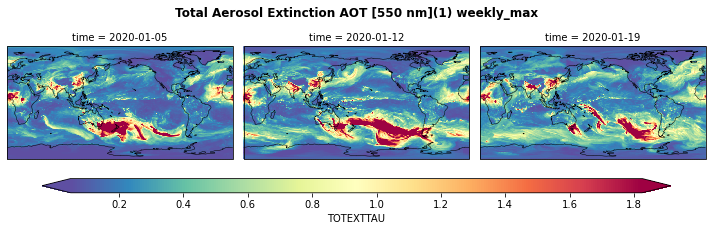

In [14]:
%%time
# ------------------------------------------------------------------
# Visualizing the evolution of Australian bushfire 
# ------------------------------------------------------------------

# 1) Plot the spatial facet map (e.g., the first three weeks)

pmap = sel_var_weekly_max.isel(time=[0,1,2]).plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='time', col_wrap=3, robust=True, # multiplot settings
             cmap=plt.cm.Spectral_r, 
             cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.9,
            "aspect": 40,
            "pad": 0.1,
                         },
            subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)})  # the plot's projection
            # shift the original central longitude from 0 to 180 

# Plot main title 
main_title = "{}{} weekly_max".format(sel_var_longname, sel_var_unit) 
plt.suptitle(main_title, fontweight='bold')

# We have to set the map's options on all axes
for ax in pmap.axes.flat:
    ax.coastlines(resolution="110m",linewidth=0.5)

# Save the plot 
file_dir = '.'
figFile_plot = "{}/map.{}.selected_time.{}.png".format(file_dir, collection_shortname,sel_var_shortname)
plt.savefig(figFile_plot, dpi=200)
print(" Pick up your figure ", figFile_plot) 

2) Plot the time series of daily mean averaged over the globe (Figure 2)

stat:
       TOTEXTTAU
count  31.000000
mean    0.134867
std     0.008216
min     0.115233
25%     0.130622
50%     0.134412
75%     0.140259
max     0.148424
 Pick up your figure  ./timeseries.M2T1NXAER.selected_time.TOTEXTTAU.png
CPU times: user 4.96 s, sys: 4.79 s, total: 9.75 s
Wall time: 9min 46s


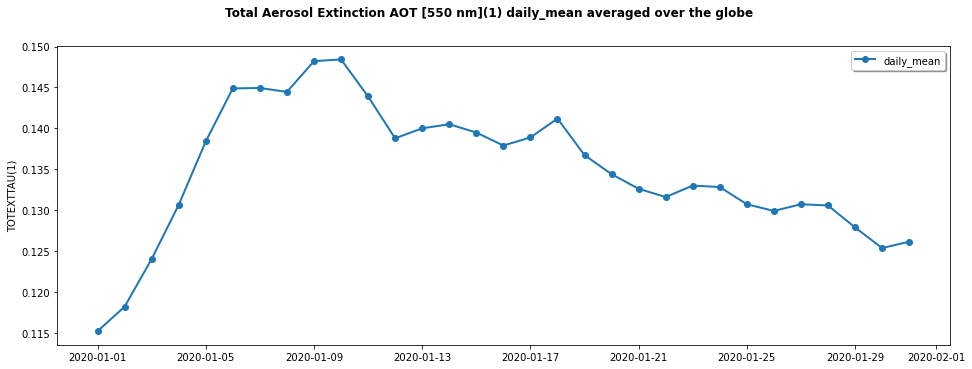

In [15]:
%%time

# 2) Plot the time series of daily mean averaged over the globe 

fig, ax = plt.subplots(figsize=(16,5.5))
sel_var_daily_mean_region = sel_var_daily_mean.groupby('time').mean(dim=['lat','lon'],skipna=True)

# Convert to dataframe 
plotdata = sel_var_daily_mean_region.to_dataframe()

# List the statistics
stat = plotdata.describe()
print("stat:")
print(stat)

# Plot time series
ax.plot(plotdata,label='daily_mean', marker="o", linewidth=2)
ax.legend(shadow=True, fancybox=True)

# Plot main title and xy labels
main_title = "{}{} daily_mean averaged over the globe".format(sel_var_longname, sel_var_unit) 
plt.suptitle(main_title, fontweight='bold')
ax.set_ylabel(sel_var_shortname+sel_var_unit)

# Save the plot
figFile_plot = "{}/timeseries.{}.selected_time.{}.png".format(file_dir, collection_shortname,sel_var_shortname)
plt.savefig(figFile_plot, dpi=200)
print(" Pick up your figure ", figFile_plot) 